In [1]:
import torchvision

from datasets import KeyboardBBoxDataset
from datasets.util import *

In [2]:
DATASET_VERSION = 2
image_paths = get_dataset_paths(DATASET_VERSION)
len(image_paths)

1000

In [3]:
mean, std = get_dataset_norm_params(DATASET_VERSION)
mean, std

(array([0.2517634 , 0.26364404, 0.27402246]),
 array([0.241223  , 0.24496816, 0.25682035]))

In [4]:
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.8, 0.16)

train_dataset = KeyboardBBoxDataset(train_paths)
valid_dataset = KeyboardBBoxDataset(valid_paths)
test_dataset = KeyboardBBoxDataset(test_paths)

len(train_dataset), len(valid_dataset), len(test_dataset)

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(640, 160, 200)

In [5]:
from torchvision.transforms import v2 as transforms

train_dataset.set_transforms([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    # transforms.RandomErasing(p=0.5),
    transforms.ToPureTensor(),
])

train_dataset.set_augmentations([
    transforms.RandomChannelPermutation(),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std)
])

{'boxes': tensor([[134, 449, 204, 480],
         [207, 405, 289, 480],
         [283, 360, 366, 440],
         [ 94, 346, 257, 473],
         [  0, 337,  22, 394],
         [360, 315, 444, 394],
         [252, 313, 314, 380],
         [142, 304, 202, 369],
         [309, 280, 372, 346],
         [ 41, 276, 146, 414],
         [198, 271, 259, 336],
         [366, 246, 430, 312],
         [126, 243, 185, 306],
         [254, 238, 315, 303],
         [423, 213, 488, 278],
         [181, 210, 240, 273],
         [ 14, 207, 127, 302],
         [310, 205, 372, 270],
         [436, 184, 640, 349],
         [480, 179, 547, 244],
         [  0, 178,  39, 238],
         [235, 178, 296, 241],
         [124, 176, 181, 237],
         [366, 172, 429, 236],
         [ 37, 147,  92, 207],
         [290, 146, 352, 208],
         [538, 145, 605, 210],
         [177, 144, 236, 205],
         [422, 139, 486, 203],
         [ 90, 116, 145, 175],
         [345, 113, 408, 175],
         [231, 112, 290, 173],

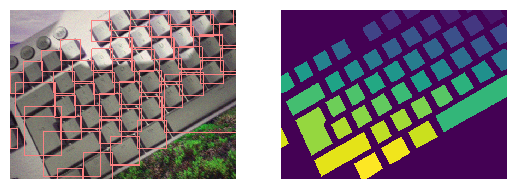

In [6]:
import random

i = random.randint(0, len(train_dataset) - 1)
train_dataset.show(i)
train_dataset[i][1]

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": True,
             "collate_fn": zip_collate_fn}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)
test_dataloader = DataLoader(test_dataset, **dl_kwargs)

In [8]:
import torch

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize


class KeyRegionFasterRCNN(pl.LightningModule):
    def __init__(self, backbone):
        super().__init__()
        
        # let's make the RPN generate 4 x 3 anchors per spatial
        # location, with 5 different sizes and 3 different aspect
        # ratios. We have a Tuple[Tuple[int]] because each feature
        # map could potentially have different sizes and
        # aspect ratios
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        # let's define what are the feature maps that we will
        # use to perform the region of interest cropping, as well as
        # the size of the crop after rescaling.
        # if your backbone returns a Tensor, featmap_names is expected to
        # be [0]. More generally, the backbone should return an
        # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
        # feature maps to use.
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=["0"],
            output_size=7,
            sampling_ratio=2
        )
        
        # put the pieces together inside a Faster-RCNN model
        self.rcnn = FasterRCNN(
            backbone,
            num_classes=2,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )

    def forward(self, *args):
        return self.rcnn(args)

    def _step(self, batch, stage):
        if trainer.global_step == 0:
            wandb.define_metric(f"{stage}_loss", summary="min")

        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        self.rcnn.train()
        loss_dict = self.rcnn(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        self.log(f"{stage}_loss", loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STEPS, eta_min=1e-5)
        return {"optimizer": optimizer}  # "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1}

In [ ]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

In [ ]:
wandb.finish()

backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs the number of output channels in backbone.
# For mobilenet_v2, it's 1280
backbone.out_channels = 1280

model = KeyRegionFasterRCNN(backbone)
model

In [ ]:
summarize(model)

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

EPOCHS = 40
LEARNING_RATE = 1e-4

PROFILE = False
profiler = "advanced" if PROFILE else None

logger = WandbLogger(project="mrover-keyboard-region-detection", group=f"MobileNetV2")
logger.experiment.config["dataset"] = DATASET_VERSION

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, profiler=profiler, logger=logger, callbacks=[checkpoint_callback],)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
torch.save(model.state_dict(), f"models/binary_segmentation/{wandb.run.name}-FRCNN-MobileNetV2-v{DATASET_VERSION}.pt")
wandb.finish()

In [12]:
model = KeyRegionDetectionModel()
model.load_state_dict(
    torch.load(f"models/binary_segmentation/fresh-water-9-FRCNN-MobileNetV2-v{DATASET_VERSION}.pt", weights_only=True))
model.eval()

KeyRegionDetectionModel(
  (rcnn): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, aff

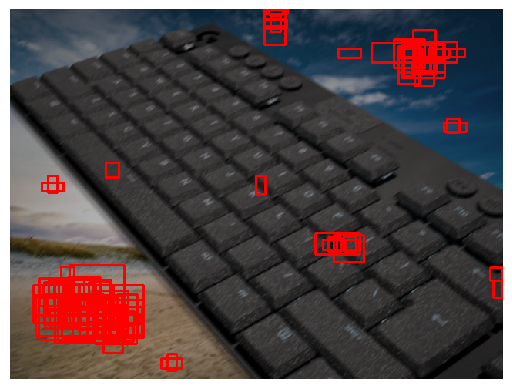

In [24]:
from utils import imshow
import cv2

img, _ = test_dataset[0]
out = model(img)[0]
img = reorder_image_axes(img.numpy()).copy()

for quad in out["boxes"]:
    x1, y1, x2, y2 = map(int, quad.detach().numpy())
    cv2.rectangle(img, (x1, y1), (x2, y2), (1.0, 0, 0), 2)

imshow(img)